# Regression Analysis to Determine Neighborhoods Underserved by Restaurants

## 1. Introduction
The restaurant industry is highly competitive, with one study finding that approximately 60% of restaurants close within the [first three years](https://daniels.du.edu/assets/research-hg-parsa-part-1-2015.pdf). Selecting the right location is critical for an entrepeneur opening a new restaurant. The goal of this analysis is to build a model that can identify neighbourhoods that are underserved by restaurants based on other business categories in the neighborhood.

## 2. Data
Foursquare API data will be the primary source of data for this analysis. For each neighborhood in the Chicago, the number of various types of businesses will be found. A regression model will be trained on this data to predict the number of restaurants in a given area based on the number of other businesses.
Neighbourhood population density will also be used to investigate if this improves the regression model.

## 3. Methodology

To determine neighbourhoods that are good candidates to open a new restaurant, a regression analysis will be completed using various [sci-kit linear models](https://scikit-learn.org/stable/modules/linear_model.html). Each model will be trained using the count of venues in a neighbourhood to predict the number of restaurants. The various models will be investigated to determine which is the best technique for this particular problem. Due to the limited number of training points available, regularization will be important to ensure the model does not overfit the data. 

### 3.1 Libraries
The machine learning algorithms used are from the scikit learn linear model package. Data analysis will be completed with Pandas and visualizations be created with Folium and Matplotlib. Geopy will be used to get coordinate data for each neighbourhood.

In [3]:
import pandas as pd
import requests
from geopy.geocoders import Nominatim
import folium
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler

### 3.2 Neighbourhood Data
Neighbourhood data for Chicago was scraped from Wikipedia using pandas read_html function. The Wikipedia page included population and area for neighbourhoods which will be used as an input for the regression model in addition to the Foursquare data. Geopy.geocoders was used to get coordinates for each neigbhourhood.

In [5]:
url = 'https://en.wikipedia.org/wiki/Community_areas_in_Chicago'


chicago_data = pd.read_html(url)[0].drop(['Number[8]','Area (sq mi.)[10]','2017density (/sq mi.)'],axis=1)
chicago_data.columns = ['Neighbourhood','Population','Area','Population Density']
chicago_data = chicago_data.iloc[:-1].replace('(The) Loop[11]','The Loop')
chicago_data['Latitude'] = None
chicago_data['Longitude'] = None
geolocator = Nominatim(user_agent='chicago_explorer')
for i,row in chicago_data.iterrows():
    location = None
    nh = row['Neighbourhood']
    while(location is None):
        location = geolocator.geocode(f'{nh}, Chicago, Illinois')
    chicago_data.loc[i,['Latitude','Longitude']] = location.latitude,location.longitude

chicago_data.head()

,Neighbourhood,Population,Area,Population Density,Latitude,Longitude
0,Rogers Park,55062,4.77,11554.11,42.009,-87.6768
1,West Ridge,76215,9.14,8336.20,42.0035,-87.6962
2,Uptown,57973,6.01,9648.06,41.9666,-87.6555
3,Lincoln Square,41715,6.63,6291.50,41.9685,-87.6887
4,North Center,35789,5.31,6740.59,41.9561,-87.6792


### 3.3 Foursquare Data
#### 3.3.1 API Call
Using a Foursquare developer account, nearby venues were found for each neighbourhood in Chicago through the Foursquare explore API. The getNearbyVenues function was provided in a previous lab to get nearby businesses for each neighborhood in New York.

In [6]:
CLIENT_ID = 'KBISHQXB1DEVMGJQJYYTQOEKQY4T0JWBOAWXA5BFQZLMKQRR'
CLIENT_SECRET = '2QE0Y5TUHG12CYQ0Q4OGYVMXHIUG2MYNKCZBC4HEWW3SACEZ'
VERSION = '20180605'
LIMIT = 250

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], 
            v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 
                  'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

#### 3.3.2 Get Venue Data and Inspect
There are **344** unique categories, with four of the top five being different types of restaurants. The goal of this analysis is to identify neighbourhoods that are underserved by restaurants, not to identify the type of restaurant to open. As a result, all restaurants should be grouped together in a single category. Foursquare provides a hierarchy of [venue categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/) that can be used to map each venue category to a higher level category.

In [11]:
chicago_venues = getNearbyVenues(names=chicago_data['Neighbourhood'],latitudes=chicago_data['Latitude'],
                                       longitudes=chicago_data['Longitude'],radius=2000)
chicago_venues['Venue Category'].value_counts()

Mexican Restaurant      277
Sandwich Place          265
Pizza Place             242
Park                    230
Fast Food Restaurant    202
                       ... 
Street Art                1
Bed & Breakfast           1
Bus Stop                  1
Poke Place                1
Military Base             1
Name: Venue Category, Length: 344, dtype: int64

In [12]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, LIMIT)
results = requests.get(url).json()
df = pd.json_normalize(results['response']['categories'],record_path='categories',meta='name',meta_prefix='lvl1_')
chicago_venues['Category'] = chicago_venues['Venue Category'].map(df.set_index('name')['lvl1_name'])
chicago_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category
0,Rogers Park,42.009037,-87.676849,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant,Food
1,Rogers Park,42.009037,-87.676849,Bark Place,42.010080,-87.675223,Pet Store,Shop & Service
2,Rogers Park,42.009037,-87.676849,Mind Crusher Tattoo,42.003801,-87.672525,Tattoo Parlor,Shop & Service
3,Rogers Park,42.009037,-87.676849,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,Mexican Restaurant,Food
4,Rogers Park,42.009037,-87.676849,Morse Fresh Market,42.008087,-87.667041,Grocery Store,NaN


### 3.4 Data Preparation
In a similar manner to the clustering exercise from Week 3, the venue categories need to be converted from a text column to a numerical representation so that the data can be an input to a regression model. The pandas get_dummies function was used to transform this colum to a set of columns for each category with a value of one in the column matching the category of the venue, and zeroes in all other columns. This transformation is called one-hot encoding.

After one hot encoding, the venues are grouped by neighbourhood. All cateogories other than "Food" are normalized by taking the average across rows. Because the "Food" category is the target variable, the values of this column are summed, giving the total number of restaurants per neighbourhood. This will help with interpreting the results of the regression, as the difference between the output of the regression and the actual count will be the surplus or shortage of restaurants.

It is important to note that grocery stores are under the "Shops & Services" category, not the "Food" category.

In [15]:
chicago_onehot = pd.get_dummies(chicago_venues[['Category']], prefix='', prefix_sep='')

# add neighborhood column back to dataframe
chicago_onehot['Neighbourhood'] = chicago_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_grouped = chicago_onehot.groupby('Neighbourhood').mean().reset_index()
chicago_grouped['Food'] = chicago_onehot.groupby('Neighbourhood').sum().reset_index()['Food']
chicago_grouped

,Neighbourhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Albany Park,0.010000,0.00,46,0.020000,0.080000,0.0,0.0,0.060000,0.000000
1,Archer Heights,0.000000,0.00,39,0.040000,0.020000,0.0,0.0,0.400000,0.040000
2,Armour Square,0.040000,0.00,39,0.070000,0.060000,0.0,0.0,0.100000,0.010000
3,Ashburn,0.013333,0.00,27,0.026667,0.093333,0.0,0.0,0.226667,0.066667
4,Auburn Gresham,0.013333,0.00,33,0.120000,0.053333,0.0,0.0,0.240000,0.026667
...,...,...,...,...,...,...,...,...,...,...
72,West Lawn,0.011236,0.00,40,0.011236,0.022472,0.0,0.0,0.202247,0.112360
73,West Pullman,0.031250,0.00,12,0.031250,0.062500,0.0,0.0,0.343750,0.031250
74,West Ridge,0.000000,0.00,51,0.010000,0.030000,0.0,0.0,0.180000,0.000000
75,West Town,0.010000,0.00,46,0.030000,0.030000,0.0,0.0,0.140000,0.000000


### 3.5 Exploratory Data Analysis
Since the goal of this analysis is to identify neighbourhood hotspots for restaurants, it will be useful to define a function to map the neighbourhoods with an attribute as the color. The heatmap will identify hot and cold spots for restaurants. To start the number of restaurants in each neighbourhood is plotted. Based on this initial analysis, there are more restaurants closer to downtown Chicago and less in the suburbs. This is expected since there should be more venues in general in more densely populated areas. As a result, further analysis is needed to determine if the suburbs are lower than expected based on other venue categories

In [16]:
location = geolocator.geocode('Chicago, IL')
latitude = location.latitude
longitude = location.longitude
cm = mpl.colors.LinearSegmentedColormap.from_list('rb',[(0,0,1),(1,1,1),(1,0,0)],N=100)

def restaurant_map(city_data,grouped_data,col,col_label):
    map = folium.Map(location=[latitude-.05, longitude], zoom_start=11)
    # add markers to map
    for i, pc in city_data.iterrows():
        rest = grouped_data.loc[grouped_data['Neighbourhood']==pc['Neighbourhood'],col]/grouped_data[col].max()
        rest_sat = mpl.colors.rgb2hex(cm(rest)[0])
        label = '{}, {}: {}'.format(pc['Neighbourhood'], col_label, grouped_data.loc[grouped_data['Neighbourhood']==pc['Neighbourhood'],col].values[0])
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [pc['Latitude'], pc['Longitude']],radius=10,popup=label,color=rest_sat,
            fill=True,fill_color=rest_sat,fill_opacity=0.7,parse_html=False).add_to(map)  
    return map

display(chicago_grouped.sort_values('Food',ascending=False).head(10))
restaurant_map(chicago_data,chicago_grouped,'Food','Restaurant Count')

,Neighbourhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
41,Lower West Side,0.04,0.0,52,0.080000,0.050000,0.000000,0.0,0.080000,0.020000
74,West Ridge,0.00,0.0,51,0.010000,0.030000,0.000000,0.0,0.180000,0.000000
6,Avalon Park,0.00,0.0,51,0.050000,0.030000,0.000000,0.0,0.190000,0.020000
27,Garfield Ridge,0.00,0.0,50,0.020000,0.030000,0.000000,0.0,0.240000,0.000000
48,Near West Side,0.04,0.0,49,0.060000,0.040000,0.020000,0.0,0.050000,0.050000
14,Chatham,0.01,0.0,48,0.080000,0.030000,0.000000,0.0,0.240000,0.010000
42,McKinley Park,0.05,0.0,47,0.030000,0.020000,0.010000,0.0,0.200000,0.040000
34,Irving Park,0.00,0.0,47,0.080000,0.050000,0.000000,0.0,0.150000,0.000000
22,Edison Park,0.02,0.0,46,0.020000,0.050000,0.010000,0.0,0.200000,0.010000
63,South Lawndale,0.00,0.0,46,0.020202,0.040404,0.010101,0.0,0.212121,0.050505


### 3.6 Regression models
To model the expected number of restaurants by neighbourhood, different linear regression models will be tested. Ordinary Least Squares, Ridge, and Lasso models will each be tested. Rigde and Lasso models use regularization to reduce the coefficients size by penalizing large coefficients, preventing overfitting. Regularization is expected to be beneficial in this case since there are only 77 neighbourhoods to train the model. Training for each regression type will be completed with 1) the venue datasets and 2) the venue dataset plus the neighbourhood population density.

#### 3.6.1 Data for Regression Models
For the initial analysis, the inputs to the model are the normalized values of each cateogry (other than "Food") for each neighborhood, and the target is the total number of food venues. A dataframe with the neighbourhood and count of food venues is initialized which will be used to store the outputs of the various models.

In [17]:
X = chicago_grouped.drop(['Neighbourhood','Food'],axis=1).values
y = chicago_grouped['Food'].values
chicago_restaurants = chicago_grouped[['Neighbourhood','Food']].copy()
scores = {}

In [18]:
chi_food = pd.merge(chicago_grouped,chicago_data[['Neighbourhood','Population Density']],on='Neighbourhood')
min_max_scaler = MinMaxScaler()
chi_food['Population Density'] = min_max_scaler.fit_transform(chi_food[['Population Density']])
X_pop = chi_food.drop(['Neighbourhood','Food'],axis=1).values

In [19]:
def predict_restuarant_count(model,X_train,y_train):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    r2 = model.score(X_train,y)
    return y_pred, model, r2

#### 3.6.2 Regression based on venue category only

In [20]:
chicago_restaurants['Linear Prediction'], linreg, scores['Linear Prediction'] = predict_restuarant_count(LinearRegression(),X,y)
chicago_restaurants['Ridge Prediction'], ridge, scores['Ridge Prediction'] = predict_restuarant_count(Ridge(alpha=.05),X,y)
chicago_restaurants['Lasso Prediction'], lasso, scores['Lasso Prediction'] = predict_restuarant_count(Lasso(alpha=.05),X,y)

#### 3.6.3 Regression with Population Density

In [21]:
chicago_restaurants['Linear Prediction (pop. density)'], linreg_pop, scores['Linear Prediction (pop. density)'] = predict_restuarant_count(LinearRegression(),X_pop,y)
chicago_restaurants['Ridge Prediction (pop. density)'], ridge_pop, scores['Ridge Prediction (pop. density)'] = predict_restuarant_count(Ridge(alpha=.05),X_pop,y)
chicago_restaurants['Lasso Prediction (pop. density)'], lasso_pop, scores['Lasso Prediction (pop. density)'] = predict_restuarant_count(Lasso(alpha=.05),X_pop,y)

In [22]:
chicago_restaurants

,Neighbourhood,Food,Linear Prediction,Ridge Prediction,Lasso Prediction,Linear Prediction (pop. density),Ridge Prediction (pop. density),Lasso Prediction (pop. density)
0,Albany Park,46,44.285959,41.888878,41.159278,44.571510,43.644357,42.968647
1,Archer Heights,39,30.576714,32.096734,33.188865,30.622982,31.974836,33.154528
2,Armour Square,39,43.039773,41.555067,41.314088,42.844832,40.884585,40.382768
3,Ashburn,27,27.924244,29.612122,29.510102,27.894052,29.372468,29.491747
4,Auburn Gresham,33,33.192453,34.474046,36.024110,33.396831,34.951557,36.098120
...,...,...,...,...,...,...,...,...
72,West Lawn,40,35.319677,34.777058,35.287709,35.268970,34.618201,35.233213
73,West Pullman,12,29.310649,31.248771,31.040794,29.349115,31.145440,31.147001
74,West Ridge,51,45.012040,42.534888,42.438734,45.161888,43.607038,43.578021
75,West Town,46,46.632784,43.891411,43.855905,46.585200,44.098238,43.972017


## 4 Results
Six different regression models were tested. Because the goal is to identify the difference between predicted and actual restaurants in all districts, the entire dataset was used to train the model. The results for each model are plotted below, with the predicted restaurant count plotted against the actual restaurant count. From an initial inspection, the results for each model appeas to be similar.

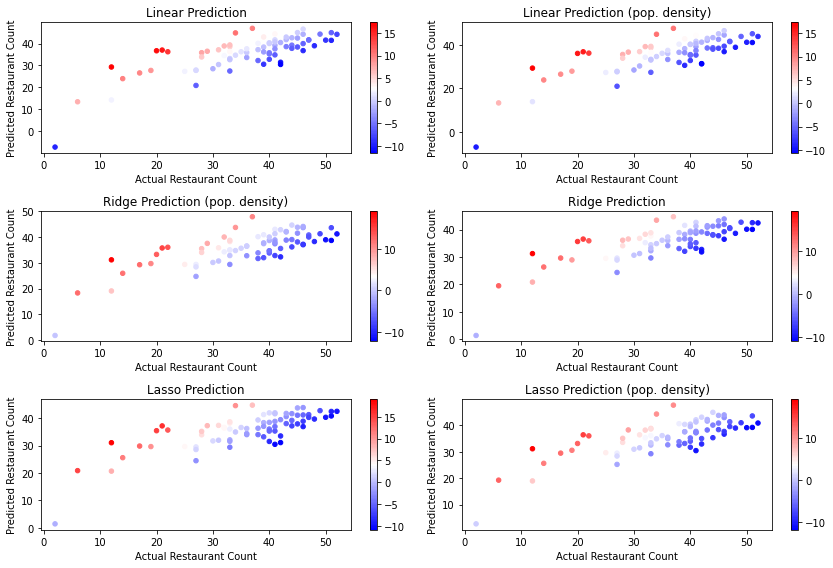

In [23]:
fig,axes = plt.subplots(3,2,figsize=(12,8))
for i, col in zip(range(6),chicago_restaurants.columns[2:]):
    chicago_restaurants.plot(ax=axes[i%3,i%2],kind='scatter',x='Food',y=col,title=col
                                 ,c=chicago_restaurants[col]-chicago_restaurants['Food'],colormap=cm)
    ax=axes[i%3,i%2].set_xlabel('Actual Restaurant Count')
    ax=axes[i%3,i%2].set_ylabel('Predicted Restaurant Count')
plt.tight_layout()

To better understand the differences between models, the coefficients and $R^{2}$ should be investigated. Due to the limited number of training points (77) and high number of input variables (8 or 9), it is important to be careful of overfitting. One indication of overfitting is large coefficient values. Looking at the coefficients of each model, the Linear Regression had much larger coefficents. Ridge and Lasso Regression penalize large coefficients with a regularization term. The coefficients for "Professional & Other Places", "College & University", and "Residence" were reduced significantly with regularization. Looking at the occurences of each category in the dataset, there are very few of each of these venues compared to the other categories.

In [24]:
coefs = []
for i,model in enumerate((linreg, ridge, lasso, linreg_pop, ridge_pop, lasso_pop)):
    coefs.append(model.coef_)
coefs = pd.DataFrame(coefs,index=chicago_restaurants.columns[2:],columns=chi_food.drop('Food',axis=1).columns[1:])
coefs.round(1)

,Arts & Entertainment,College & University,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Population Density
Linear Prediction,18.3,0.0,-31.6,-136.0,-43.0,576.2,-51.7,-86.6,NaN
Ridge Prediction,21.4,1.7,-16.8,-102.6,-4.7,1.7,-37.0,-70.5,NaN
Lasso Prediction,0.0,0.0,-0.0,-110.6,-0.0,0.0,-35.4,-64.0,NaN
Linear Prediction (pop. density),18.6,10.3,-29.2,-133.9,-43.8,566.0,-49.5,-84.1,1.6
Ridge Prediction (pop. density),21.0,2.8,-11.4,-95.7,-5.1,1.7,-29.6,-62.7,6.8
Lasso Prediction (pop. density),0.0,0.0,-0.0,-100.8,-0.0,0.0,-27.0,-55.6,6.9


In [25]:
chicago_venues.groupby('Category')['Neighbourhood'].count()

Category
Arts & Entertainment            158
College & University              8
Food                           2755
Nightlife Spot                  294
Outdoors & Recreation           400
Professional & Other Places      22
Residence                         2
Shop & Service                 1205
Travel & Transport              205
Name: Neighbourhood, dtype: int64

Based on the coefficients, it appears that the Ridge or Lasso method provide a better model with less risk of overfitting. Looking at the $R^{2}$ values for each model, there is not a large difference between any of the models, and each regression method provides similar performance with or without the population density included. Further analysis will be completed with the Ridge method, excluding population density data.

In [26]:
scores = pd.DataFrame(scores,index=[0])
scores.round(3)

,Linear Prediction,Ridge Prediction,Lasso Prediction,Linear Prediction (pop. density),Ridge Prediction (pop. density),Lasso Prediction (pop. density)
0,0.615,0.577,0.565,0.616,0.576,0.562


Using the predicted values of the Ridge regression, the restaurant shortage can be calculated for each neigbhourhood. Postive values indicate a neighbourhood that has less restaurants than expected, while negative values indicate a neighbourhood has more restaurants than it would be expected to support based on the profile of the neighbourhood's other venues.

In [27]:
chicago_restaurants['Restaurant Shortage'] = (chicago_restaurants['Ridge Prediction'] - chicago_restaurants['Food']).round(2)
chicago_restaurants_shortage = chicago_restaurants.drop(['Linear Prediction','Lasso Prediction','Linear Prediction (pop. density)','Ridge Prediction (pop. density)'
                                                ,'Lasso Prediction (pop. density)'],axis=1).merge(chicago_data,on='Neighbourhood')
chicago_restaurants_shortage.head()

,Neighbourhood,Food,Ridge Prediction,Restaurant Shortage,Population,Area,Population Density,Latitude,Longitude
0,Albany Park,46,41.888878,-4.11,51992,4.97,10455.33,41.9703,-87.716
1,Archer Heights,39,32.096734,-6.90,13142,5.21,2524.46,41.8114,-87.7262
2,Armour Square,39,41.555067,2.56,13455,2.59,5195.00,41.8402,-87.633
3,Ashburn,27,29.612122,2.61,43792,12.59,3479.05,41.7475,-87.7112
4,Auburn Gresham,33,34.474046,1.47,46278,9.76,4739.53,41.7432,-87.6537


## 5 Discussion
### 5.1 Target Neighbourhoods

Looking at the restaurant shortage or surplus based on the comparison of the Ridge regression to actual restaurant counts, there are 9 neighbourhoods that vary by more than 10 restaurants from the expected value. Three neighbourhoods have a surplus of 10 restaurants, which suggests there may be more restaurants in this neighbourhood than can be supported based on the other venues. There are seven neighbourhoods with a shortage of more than 10 restaurants. These neighbourhoods are good candidates for opening a new restaurant. West Pullman in particular has a shortage of 23 restaurants versus expected. Further analysis should be completed to identify whether there is a factor causing this shortage or if this is indeed a candidate for a new restaurant.

In [28]:
chicago_restaurants_shortage[chicago_restaurants_shortage['Restaurant Shortage'].abs()>10].sort_values('Restaurant Shortage',ascending=False)

,Neighbourhood,Food,Ridge Prediction,Restaurant Shortage,Population,Area,Population Density,Latitude,Longitude
73,West Pullman,12,31.248771,19.25,27742,9.22,3008.78,41.675,-87.6378
57,Pullman,20,35.659720,15.66,6613,5.49,1204.38,41.6922,-87.6066
23,Englewood,21,36.548791,15.55,25075,7.95,3153.59,41.7798,-87.6459
5,Austin,22,35.916159,13.92,95260,18.52,5144.07,41.888,-87.7649
30,Hegewisch,6,19.492470,13.49,9418,13.57,693.95,41.6536,-87.547
20,East Side,17,29.631122,12.63,23737,7.72,3075.47,41.6946,-87.5334
61,South Chicago,14,26.353328,12.35,28263,8.65,3267.19,41.7346,-87.5513
59,Rogers Park,42,31.861772,-10.14,55062,4.77,11554.11,42.009,-87.6768
6,Avalon Park,51,40.080970,-10.92,9985,3.24,3084.18,41.745,-87.5887


Visualizing the results on a map shows that many of the candidate neighbourhoods (shown in red) are on the south side of Chicago. However there are candidate neighbourhoods throughout the city, with multiple neighbourhoods on the north side with a restaurant shortage greater than 5.

In [54]:
restaurant_map(chicago_restaurants_shortage,chicago_restaurants_shortage,'Restaurant Shortage','Expected Restaurant Surplus')

### 5.2 Population Density
It was expected that adding the population density would improve the ability of the model to predict the number of restaurants. However, the $R^{2}$ values barely changed after adding in the population density. This suggests that the effect of population density is already captured by looking at other venues in the neighbourhood (i.e. locations with a high number of businesses are likely to have a high population density).

In [30]:
scores

,Linear Prediction,Ridge Prediction,Lasso Prediction,Linear Prediction (pop. density),Ridge Prediction (pop. density),Lasso Prediction (pop. density)
0,0.615013,0.577341,0.564599,0.615764,0.575668,0.562175


## 6 Conclusion

Foursquare venue data could be used to identify initial target neighbourhoods for a new restaurant based on the other types of venues in the neighbourhood. This provides a high-level target area for a potential restaunteur. By visualizing the restaurant shortage by neighbourhood on a map, the results of the analysis are clearly communicated. The analysis showed that there are favourable neighbourhoods on the south side of Chicago for a new restaurant, with West Pullman, Pullman, and Englewood as the top candidates. This initial analysis shows the capability of Foursquare data to assist entrepeneurs select the best location for their new business.

Although this analysis identified potential targets, before opening a restaurant further analysis should be completed to verify the suitability of the neighbourhood. The analysis could be improved by adding factors such as age and disposable income by neighbourhood and restaurant size. A limitatino is that this analysis treats all restaurants equally. Additional analysis could be completed to identify the type of restaurant that would be more likely to succeed. An example of this would be a neighbourhood that has a shortage of restaurants, but with a high percentage of restaurants being takeout establishments. In this scenario, a family dining or sit down restaurant may be a better choice, but this could be due to the particular demographics of the neighbourhood. This analysis could be further improved by training with data from multiple cities and classifying neighbourhoods as urban or suburban.